In [6]:
import kfp
import kfp.dsl as dsl
import kfp.onprem as onprem
import kfp.components as comp
    
def echo_op(text):
    return dsl.ContainerOp(
        name='echo',
        image='library/bash:4.4.23',
        command=['sh', '-c'],
        arguments=['echo "$0"', text],
    )  

@dsl.pipeline(
    name='FMnistPipeline',
    description='mnist '
)
def fmnist_pipeline(learning_rate, dropout_rate, epoch, act, layer,  
                    checkpoint_dir, saved_model_dir, pvc_name, tensorboard_log,
                    name, model_version, namespace):
  
    exit_task = echo_op("Done!")
    
    with dsl.ExitHandler(exit_task): 

        kubeflow_pvc = dsl.PipelineVolume(pvc=str(pvc_name))
        
        fmnist = dsl.ContainerOp(
            name='FMnist',
            image='kubeflow-registry.default.svc.cluster.local:30000/katib-job:3F6886A4',
            command=['python', '/app/fmnist-save-model.py'],
            arguments=[
                "--learning_rate", learning_rate,
                "--dropout_rate", dropout_rate,
                "--epoch", epoch,
                "--act", act,
                "--layer", layer,
                "--checkpoint_dir", checkpoint_dir,
                "--saved_model_dir", saved_model_dir,
                "--model_version", model_version,
                "--tensorboard_log", tensorboard_log
            ],
            pvolumes={"/pv": kubeflow_pvc}
        )
        
        kfserving = dsl.ContainerOp(
            name='kfserving',
            image='kubeflow-registry.default.svc.cluster.local:30000/kfserving:763D141E',
            command=['python', '/app/fmnist-kfserving.py'],
            arguments=[
                "--namespace", namespace,
                "--storage_uri", "pvc://" +  str(pvc_name) + "/saved_model",
                "--name", name
            ],
            pvolumes={"/pv": kubeflow_pvc}
          )
        kfserving.after(fmnist)
    

arguments = {'learning_rate': '0.0010085',
             'dropout_rate': '0.44477',
             'epoch' : '5',
             'act' : 'tanh',
             'layer': '2',
             'checkpoint_dir': '/pv/training_checkpoints',
             'saved_model_dir':'/pv/saved_model/',
             'pvc_name' : 'workspace-vscode-server',
             'tensorboard_log': '/pv/log',
             'name' : 'kfserving-fmnist',
             'model_version' : '0003',
             'namespace' : 'kubeflow-user-example-com'
            }
    
if __name__ == '__main__':
    kfp.Client().create_run_from_pipeline_func(pipeline_func=fmnist_pipeline, 
                                               arguments=arguments,
                                               namespace='kubeflow-user-example-com')

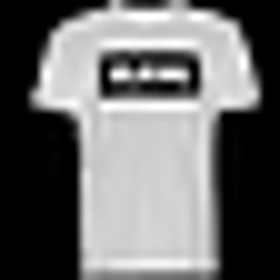

In [7]:
import numpy as np
from PIL import Image
import json

im = Image.open('fashion1.png')
width, height = im.size
im.resize((280,280)).show()

pix = np.array(im).flatten()
input = { "instances": [{ "flatten_input": pix.tolist() }] }
f = open("input.json", "w")
f.write(json.dumps(input))
f.close()